![Title](cisco.png)

# Lab - Advanced Data Visualization 

### Scenario/Background
Aprenderá como combinar bases de datos `SQLite`, archivos `JSON`, y `pandas` `DataFrame`. 
Contará con un interfaz con un wrapper para la biblioteca `folium`, que le permite graficar datos en un mapa geográfico. 

## Part 1: Prepare the data

Los datos están en una base de datos de SQLite y deseamos tenerla en un `pandas` `DataFrame`.

##### Step 1: Get the data and store it in a `pandas` `DataFrame`.

Para obtener los datos nos conectaremos a la base de datos "InternetSpeed".

###### a) Import the libraries.
- `pandas`
- `numpy`
- `sqlite3`
- `pyplot` (and use the style fivethirtyeight, or another one if you prefer)
- `folium_utils`

In [6]:
!pip install folium

    100% |████████████████████████████████| 92kB 5.1MB/s ta 0:00:01


In [10]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import folium
import folium_utils

%matplotlib inline

###### b) Connect to the database    ./InternetSpeed.db   

In [11]:
# Create the connection to the database
conn = sqlite3.connect("InternetSpeed.db")
# Create a cursor
cur = conn.cursor()

La bbdd contiene una tabla con el `average_speed`, la `average ping time` y la `velocidad de descarga promedio` para las diversas autoridades locales de Inglaterra.

    pd.read_sql(query)

###### c) Store the data in a `DataFrame`.
1. Escriba la consulta para seleccionar todos los datos de la tabla `average_speed`.
2. Use `pandas` para colocar los resultados en un `DataFrame`.


In [22]:
# Create a query to select all the data in the table average_speed
df = pd.read_sql("""SELECT * FROM average_speed""", conn)

###### Step 2: Clean the data.

###### a) Explore the data.
Print the first few rows of the `DataFrame` df.

In [23]:
df.head()

,index,Area,Average_p,Average_u,Average_d
0,0,E07000188,8.451897,21.114114,51.967713
1,1,E07000101,8.317833,20.733028,51.709226
2,2,E09000030,8.983481,22.469438,54.412001
3,3,E09000031,8.956481,22.353593,55.138017
4,4,E09000032,9.144285,22.859003,55.962499


La columna `index` no es necesaria.

###### b) Clean the data.
Elimina la columna `index` del `DataFrame`.
El cambio será efectivo si el parámetro `inplace` está a True.

In [25]:
# Code Cell 5
df.drop(['index'], inplace=True,axis=1)

print(df.shape)
df.head()

(326, 4)


,Area,Average_p,Average_u,Average_d
0,E07000188,8.451897,21.114114,51.967713
1,E07000101,8.317833,20.733028,51.709226
2,E09000030,8.983481,22.469438,54.412001
3,E09000031,8.956481,22.353593,55.138017
4,E09000032,9.144285,22.859003,55.962499


##### Step 3: Learn about `JSON` files.

El mapa codificado por colores indica la velocidad relativa de Internet en un área en relación con otras áreas.
El archivo `JSON` contiene las coordenadas de los límites de cada autoridad local.

###### a) Open and observe the file.
    
    LA_poligons.json

###### b) Read `LA_poligons.json` into a `pandas` `DataFrame`, and then visualize the first few rows. 

In [26]:
# Read the JSON file into a DataFrame
la_json = pd.read_json("LA_poligons.json")

# Visualize the first rows of la_json DataFrame
la_json.head()

,LA_code,geometry
0,E06000001,"{u'type': u'MultiPolygon', u'coordinates': [[[..."
1,E06000002,"{u'type': u'MultiPolygon', u'coordinates': [[[..."
10,E06000011,"{u'type': u'MultiPolygon', u'coordinates': [[[..."
100,E07000068,"{u'type': u'Polygon', u'coordinates': [[[0.357..."
101,E07000069,"{u'type': u'MultiPolygon', u'coordinates': [[[..."


In [76]:
la_json.shape

(380, 2)

##### Step 4: Average the ping speed.
Para cada mapa que se produzca, solo se podrá visualizar uno de los tres indicadores de velocidad de internet (average ping, upload speed, or download speed).

###### a) Prepare the data.
Genere un nuevo `pandas` `DataFrame` que contenga sólo las columnas: `Area` y `Average_p`, seleccionelas del `DataFrame` que contiene `InternetSpeed`. 
Renombre la columna `Area` por `LA_code`, usando el método`rename()`.

    columns={'Area':'LA_code'}

In [32]:
#Creamos un nuevo Dataframe
dfp = df[['Area', 'Average_p']]

#Renombramos las columnas
dfp=dfp.rename(columns={'Area':'LA_code'})

#Mostramos las primeras líneas del nuevo df
dfp.head()

,LA_code,Average_p
0,E07000188,8.451897
1,E07000101,8.317833
2,E09000030,8.983481
3,E09000031,8.956481
4,E09000032,9.144285


`folium` utiliza sólo 6 colores diferentes para definir un mapa de colores, el indicador de velocidad de Internet se dividio en 6 cubos y cada uno de ellos estará vinculado a un color diferente. 
Los cubos deben definirse para maximizar las diferencias entre las diferentes áreas, para elegir los cubos es recomendable observar el rango de los datos.

In [33]:
print(dfp.Average_p.min())
print(dfp.Average_p.max())

0.0
11.999447541819524


El tiempo del ping se encuentra en el intervalo 0-12. Si los cubos se eligen para ser [0, 10, 20, 30, 40, 50], todos los datos irían al primer cubo y todas las áreas se representarían con el primer color. 
Un buen punto de partida es considerar el rango donde se alojan datos en vivo y dividirlo en seis partesdistintas.

Para crear cubos, utilice el método `numpy` `arange()`. Considera como entrada, el valor mínimo del rango, el valor máximo y la transferencia. Si se requiere 6 cubis en el rango 1 a 12:

    np.arange(1, 12, (12-1)/6)

###### b) Select good bins for visualization.

In [34]:
# Cree rango de 6 valores y agréguelo a una lista
p_bins = np.arange(1, 12, (12-1)/6)

p_bins = list(p_bins)
print(p_bins)

[1.0, 2.833333333333333, 4.666666666666666, 6.499999999999999, 8.333333333333332, 10.166666666666664]


## Part 2: Visualize the data

##### Step 1: Plot the data on a map.

###### a) Learn about the `folium_utils` code.

El archivo `folium_utils.py` contiene algunas funciones que utilizan la biblioteca `folium`.  

Para generar el primer mapa, utilice la función
    
        folium_top_x_preds_mapper()

###### b) Call the function `folium_top_x_preds_mapper()` with the following parameters:

- The `Dataframe` that contains the data to be visualized (`dfp`)
- The `Dataframe` that contains the coordinates of the polygons (`la_json`)
- The name of the column on which to merge the two `DataFrames` (LA_code)
- The name of the column that contains the data to plot (Average_p)
- The list containing the limits of the bins (`p_bins`)

In [35]:
# Create the map
mymap = folium_utils.folium_top_x_preds_mapper(dfp, la_json, 'LA_code', 'Average_p' ,p_bins)
mymap

Length mismatch 326 325


La cantidad de autoridades locales de las dos estructuras de datos `dfp` y `la_json` no coincide y`Folium` arroja un error.

###### c) Plot the column Average_p.

Puede activar el método`plot()` directamente en la columna que desee graficar (`dfp.Average_p.plot()`). 

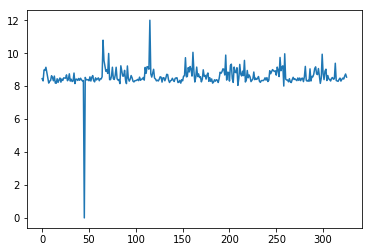

In [36]:
# Plot the column Average_p
dfp.Average_p.plot()

Hay una autoridad local para la cual la velocidad promedio de Internet es 0.

###### d) Select the row in which the average speed is zero from the `DataFrame`.

In [37]:
dfp.iloc[45]

LA_code      DateTime
Average_p           0
Name: 45, dtype: object

##### Step 2: Fix the data and plot the data on a map again.

###### a) Remove the wrong row from your `DataFrame` 

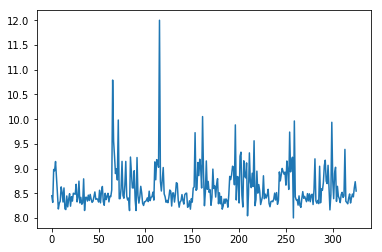

In [40]:
# hint: you can use the index (45) to remove the row
dfp.drop([45],inplace=True, axis=0)

# Plot here the cleaned data
dfp.Average_p.plot()

#### Attention!####

If using Chrome, there is currently a limit on the size of map that can be correctly visualized inside a notebook. To this end, we need to limit the size of the `dfp` `DataFrame` to the first 50 rows. The discrepancy in the size of the `dfp` and `la_json` `DataFrame`'s in this case will not cause an error, because `dfp` cannot be bigger than `la_json`, but it can be smaller.
This is operation is not needed if using Firefox.

In [41]:
# resize the dfp DataFrame. This operation is not needed if using Firefox
dfp = dfp.iloc[0:51]


###### b) Call the function  `folium_top_x_preds_mapper()` again , with the same parameters as before.

In [79]:
# Create the map
mymap = folium_utils.folium_top_x_preds_mapper(dfp, la_json, 'LA_code', 'Average_p' ,p_bins)
mymap

TypeError: __init__() missing 1 required positional argument: 'geo_data'

In [54]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'
state_unemployment = f'{url}/US_Unemployment_Oct2012.csv'
state_data = pd.read_csv(state_unemployment)

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['State', 'Unemployment'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)'
).add_to(m)

folium.LayerControl().add_to(m)

m

Deberá visualizar un mapa con sólo dos colores para los cubos 6 a 8 y 8 a 10. El valor 0 fur eliminado, pero el rango de los cubo no se modificó.

In [80]:
print(dfp.Average_p.min())

8.154217069047325


Necesario repetir la creación de cubo.

###### c) Recreate the bin range, recreate the map, and visualize it.

In [81]:
p_bins = np.arange(8, 12, (12-8)/6)
p_bins = list(p_bins)

mymap = folium_utils.folium_top_x_preds_mapper(dfp, la_json, 'LA_code', 'Average_p' ,p_bins)
mymap

TypeError: __init__() missing 1 required positional argument: 'geo_data'

<font size='0.5'>&copy; 2017 Cisco and/or its affiliates. All rights reserved. This document is Cisco Public.<font>